In [1]:
import sys
import os
# Dynamically get the path of the current directory
current_dir = os.getcwd()

# Assuming the package is one level up
local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
sys.path.insert(0, local_package_dir)

# Now you can import your local package
from util import validate



In [2]:
#from truthnet.util import validate
import pandas as pd

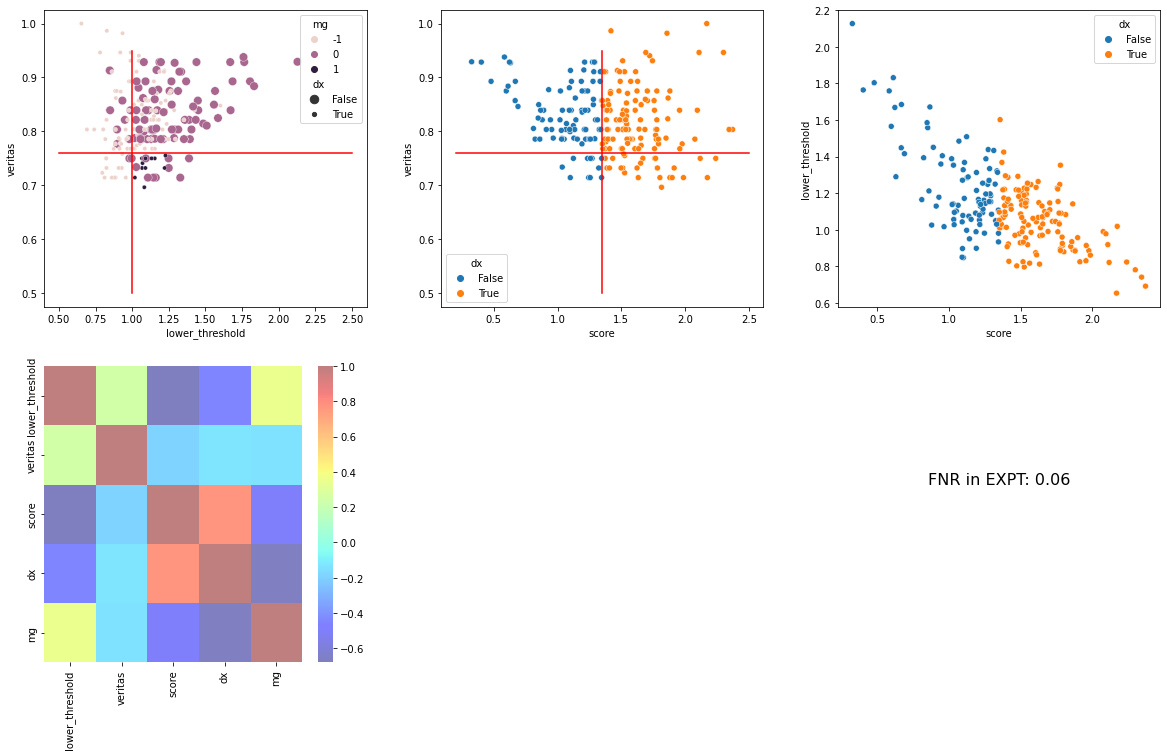

In [3]:
resf=pd.read_csv('../../data/res_exp_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
d1,wf1=validate(resf,C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid.png',
         validation_type='fnrexpt')

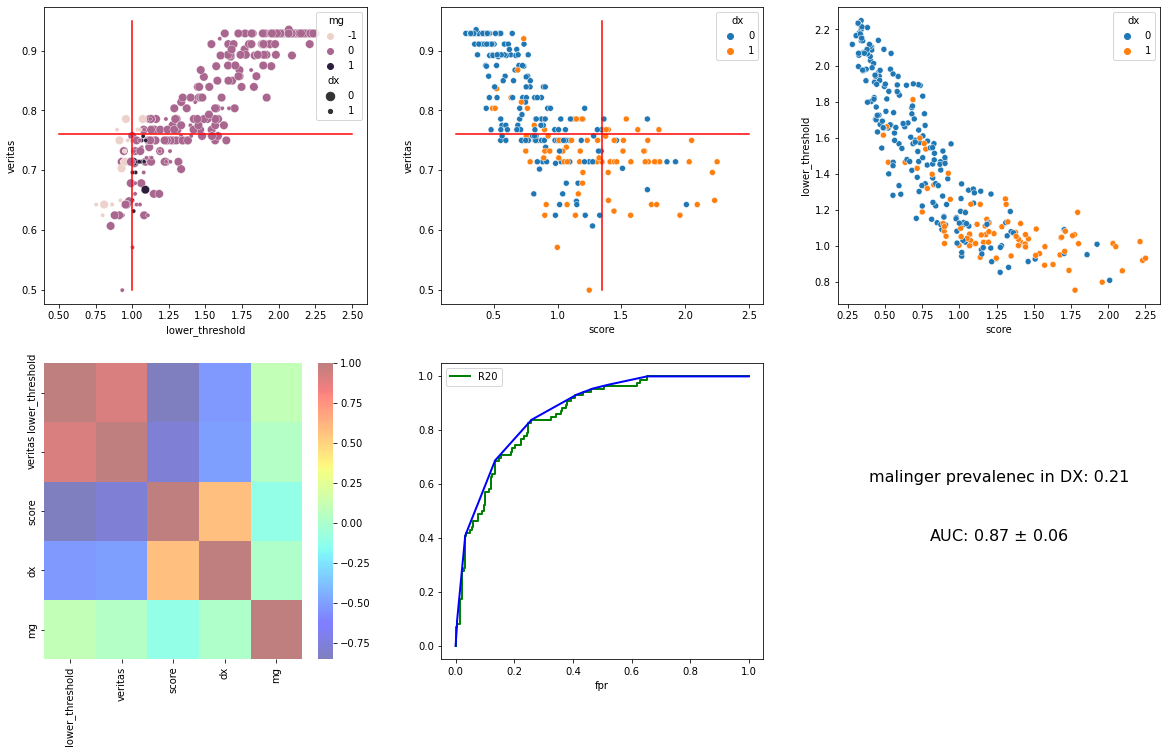

In [4]:
resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]
d2,wf2,zt=validate(resf,C0=1,C1=0.76,C2=1.35,DX=True,score=True,verbose=False,
         outfile='ptsdvalid.png',
         validation_type='withdx')

In [5]:
from truthnet import load_veritas_model

In [6]:
M=load_veritas_model('../../veritas_models/veritas_002.pkl.gz')

In [7]:
M

{'version': '0.0.1',
 'model': qnet.Qnet,
 'model_neg': qnet.Qnet,
 'problem': '',
 'calibration_lower': array([1.20398725, 1.20398725, 1.20398725, ..., 1.29696621, 1.29880653,
        1.29880653]),
 'calibration_veritas': array([0.65791448, 0.65791448, 0.65791448, ..., 0.69963702, 0.68822158,
        0.68822158]),
 'dist_lower': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f833291bc10>,
 'LOWER_THRESHOLD': 1.1457407246215392,
 'dist_veritas': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f8332928580>,
 'VERITAS_THRESHOLD': 0.6971038897415065,
 'upper_scoretoprobability': <bound method processRoc.scoretoprobability of <zedstat.zedstat.processRoc object at 0x7f8332929600>>,
 'UPPER_THRESHOLD': 1.2683587177075477,
 'AUC': (0.844551724137931, 0.8521131405190563, 0.8369903077568057)}

In [8]:
lf=M['calibration_lower']
xmin,xmax=1,1.4
ld=M['dist_lower']

In [9]:
vf=M['calibration_veritas']
vd=M['dist_veritas']
xmind,xmaxd=vf.min(),vf.max()

In [10]:
wf2.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
wf2

,$\kappa$,$\nu$,$\mu$,DX,$\chi$
CAT10050,1.766693,0.901883,0.680022,0,0
CAT10010,0.928472,0.714286,1.248364,0,0
CAT10020,1.117376,0.785714,1.025116,0,0
CAT10030,1.308874,0.767857,1.061628,0,0
CAT10040,1.775565,0.892857,0.684865,0,0
...,...,...,...,...,...
CAT12990,1.286232,0.767857,0.606269,0,0
CAT13011,1.133075,0.720779,1.325811,1,0
CAT13020,1.523528,0.793067,0.720745,0,0
CAT13040,1.895962,0.910714,0.444272,0,0


In [60]:
resf1=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf1.columns=['lower_threshold','veritas','score']

resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]

import numpy as np
from tqdm import tqdm
R={}
for c0 in tqdm(np.arange(.8,1.1,.05)):
    for c2 in tqdm(np.arange(1.1,2,.05)):
        b,_,_=validate(resf,C0=c0,C1=0.76,C2=c2,DX=True,
                   score=True,plots=False,verbose=False,
                   validation_type='withdx')
    
        a,_=validate(resf1,C0=c0,C1=0.76,C2=1.35,DX=False,score=True,plots=False,
                   validation_type='fnrexpt')

        R[(c0,c2)]=(1-a['fnr'],1-b['mratio'],1 - 0.5*(a['fnr'] + b['mratio']+a['fnr']*b['mratio'] ))

rf=pd.DataFrame(R).T
rf.columns=['sensitivity','maxspecificity','minauc']
print(rf)

rf.index.name='thresholds'
rff=rf[['sensitivity','maxspecificity']].reset_index()
rff=rff.rename(columns={'sensitivity':'tpr'})
rff['fpr']=1-rff.maxspecificity
rff=rff.drop('maxspecificity',axis=1)
print(rff)

from zedstat import zedstat
ztm=zedstat.processRoc(df=rff,
                      order=3, 
                      total_samples=304+210,
                      positive_samples=210,
                      alpha=0.01,
                      prevalence=0.31)
ztm.smooth(STEP=0.1)
ztm.allmeasures(interpolate=True)
ztm.usample(precision=2)
ztm.auc()

100%|█████████████████████████████████████████████| 7/7 [04:35<00:00, 39.41s/it]

          sensitivity  maxspecificity    minauc
0.8 1.10         0.86        0.860465  0.850465
    1.15         0.86        0.895349  0.870349
    1.20         0.86        0.918605  0.883605
    1.25         0.86        0.918605  0.883605
    1.30         0.86        0.918605  0.883605
...               ...             ...       ...
1.1 1.75         0.99        0.860465  0.924535
    1.80         0.99        0.906977  0.948023
    1.85         0.99        0.918605  0.953895
    1.90         0.99        0.918605  0.953895
    1.95         0.99        0.918605  0.953895

[126 rows x 3 columns]
     level_0  level_1   tpr       fpr
0        0.8     1.10  0.86  0.139535
1        0.8     1.15  0.86  0.104651
2        0.8     1.20  0.86  0.081395
3        0.8     1.25  0.86  0.081395
4        0.8     1.30  0.86  0.081395
..       ...      ...   ...       ...
121      1.1     1.75  0.99  0.139535
122      1.1     1.80  0.99  0.093023
123      1.1     1.85  0.99  0.081395
124      1.1     1.9

(0.9450499999999998, 0.9624863532527748, 0.927613646747225)

In [61]:
ztm.get().dropna()

,tpr,ppv,acc,npv,LR+,LR-
fpr,,,,,,
0.10,0.990110,0.821350,0.925871,0.995071,10.536538,0.011026
0.11,0.990220,0.815669,0.919028,0.995071,10.430577,0.011026
0.12,0.990330,0.809987,0.912185,0.995071,10.324615,0.011026
0.13,0.990440,0.804305,0.905342,0.995071,10.218654,0.011026
0.14,0.990549,0.798624,0.898499,0.995071,10.112692,0.011026
...,...,...,...,...,...,...
0.96,0.999560,0.332727,0.337372,0.995071,1.423846,0.011026
0.97,0.999670,0.327045,0.330529,0.995071,1.317885,0.011026
0.98,0.999780,0.321363,0.323686,0.995071,1.211923,0.011026


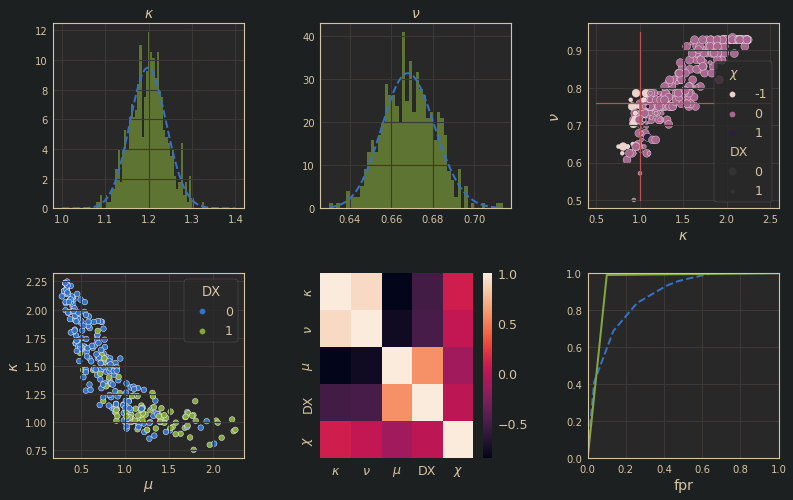

In [62]:
import numpy as np
import pylab as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()


#plt.style.use('seaborn-talk')

plt.figure(figsize=[13,8])
plt.subplots_adjust(wspace=0.4, hspace=0.35)

# First subplot
plt.subplot(231)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, ld.pdf(x), '--',lw=2)
plt.hist(lf, bins=50, density=True, alpha=0.6)
#plt.xlabel('X-axis label', fontsize=12)  # Set font size for x-label
#plt.ylabel('Y-axis label', fontsize=12)  # Set font size for y-label
plt.title('$\kappa$', fontsize=14)    # Set font size for title

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Second subplot
plt.subplot(232)
xd = np.linspace(xmind, xmaxd, 100)
plt.plot(xd, vd.pdf(xd), '--',lw=2)
plt.hist(vf, bins=50, density=True, alpha=0.6)
plt.title(r"$\nu$", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

# First subplot
plt.subplot(233)
C0=1
C1=0.76
C2=1.25
#ax=sns.scatterplot(data=response_dataframe,x='score',y='veritas',hue='dx')
#plt.plot([.2,2.5],[C1,C1],'-r')
#plt.plot([C2,C2],[.5,.95],'-r')
sns.scatterplot(data=wf2,x=r'$\kappa$',y=r'$\nu$',hue=r'$\chi$',size='DX')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);



# First subplot
plt.subplot(234)
sns.scatterplot(data=wf2,x=r'$\mu$',y=r'$\kappa$',hue='DX')
#plt.plot([.2,2.5],[C0,C0],'-r')
#plt.plot([C2,C2],[.5,2],'-r')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);


# First subplot
plt.subplot(235)
sns.heatmap(wf2.corr())


# First subplot
plt.subplot(236)
zt.get().tpr.plot(lw=2,style='--')
ztm.get().tpr.plot(lw=2)
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

plt.savefig('fig2.pdf',dpi=600,bbox_inches='tight',transparent=True)


In [12]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [34]:
pf=pd.read_csv('../../veritas-experiment/prolific_export_659b69ff0a427599bec1d811.csv')

In [58]:
pf=pf[pf.Status=='APPROVED']

In [59]:
tf=pd.read_csv('../../veritas-experiment')

,Submission id,Participant id,Status,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,Total approvals,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status
0,659b7606f086ca557624bf21,654a2cd129403e4f45596b55,APPROVED,2024-01-08T04:11:55.272000Z,2024-01-08T04:15:51.512000Z,2024-01-08T05:02:43.449000Z,2024-01-08T04:15:51.966785Z,237.0,CLK2WKL4,224,24,Male,White,United States,United States,United States,English,No,Unemployed (and job seeking)
1,659b760eeb90eb6be81a44c2,5757a0d300ca3200072678fa,APPROVED,2024-01-08T04:12:02.256000Z,2024-01-08T04:15:20.787000Z,2024-01-08T05:02:49.458000Z,2024-01-08T04:15:21.257058Z,199.0,CLK2WKL4,255,42,Female,White,United States,United States,United States,English,No,Part-Time
2,659b76a40bbd7cebb5bf769e,548cdd6bfdf99b586046fb39,APPROVED,2024-01-08T04:14:34.111000Z,2024-01-08T04:17:15.805000Z,2024-01-08T05:02:44.005000Z,2024-01-08T04:17:16.621933Z,162.0,CLK2WKL4,833,37,Male,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED
3,659b76e05c81457c876ef7e0,654516c692090350312a53c1,APPROVED,2024-01-08T04:17:54.890000Z,2024-01-08T04:21:25.181000Z,2024-01-08T05:02:52.722000Z,2024-01-08T04:21:25.624479Z,211.0,CLK2WKL4,68,29,Male,Mixed,United States,United States,United States,English,No,DATA_EXPIRED
4,659b76e0c0267a15dd63276d,5f481cf6eb2e882bb0e972b9,APPROVED,2024-01-08T04:15:38.885000Z,2024-01-08T04:18:22.412000Z,2024-01-08T05:02:48.488000Z,2024-01-08T04:18:22.855505Z,164.0,CLK2WKL4,73,33,Male,White,United States,United States,United States,English,No,Full-Time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,659b7e4668c318d68a1fe14d,6110d53a0015ee5578a3a477,APPROVED,2024-01-08T04:47:05.727000Z,2024-01-08T04:48:51.541000Z,2024-01-08T05:04:52.667000Z,2024-01-08T04:48:52.042236Z,106.0,CLK2WKL4,447,25,Male,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED
96,659b7e49b33f67b4dfc1c793,65345c123ea7ca867237e6e0,APPROVED,2024-01-08T04:47:10.799000Z,2024-01-08T04:49:09.681000Z,2024-01-08T05:04:51.019000Z,2024-01-08T04:49:10.140574Z,119.0,CLK2WKL4,153,19,Male,Asian,United States,United States,United States,English,Yes,"Not in paid work (e.g. homemaker', 'retired or..."
97,659b7e4cff76317c84f90609,5c46315c85b76000017ce729,APPROVED,2024-01-08T04:47:18.918000Z,2024-01-08T04:58:53.391000Z,2024-01-08T05:04:39.327000Z,2024-01-08T04:58:53.848404Z,695.0,CLK2WKL4,1216,31,Female,Black,United States,United States,United States,English,No,DATA_EXPIRED
98,659b7e525c81457c876ef848,6131ba00bd67d2702e9a3c8d,APPROVED,2024-01-08T04:47:18.549000Z,2024-01-08T04:51:17.908000Z,2024-01-08T05:04:38.514000Z,2024-01-08T04:51:18.302933Z,240.0,CLK2WKL4,1044,26,Female,White,United States,United States,United States,English,No,Part-Time


In [ ]:
respjsonpath='../../response_jsons/experiment.pkl.gz'

In [38]:
import gzip
import dill as pickle
with gzip.open(respjsonpath,'rb') as file:
    rsj=pickle.load(file)

In [43]:
import glob
respjsons=glob.glob('../../veritas-experiment/*json')
respjsons

['../../veritas-experiment/predictions_b661943c-e859-4d1e-8aad-b12834224719.json',
 '../../veritas-experiment/predictions_5b1e36e0-45c1-42fb-af4a-dc9c3cd818e0.json',
 '../../veritas-experiment/predictions_c7776ac9-033d-4813-b8c5-9373670c97c1.json',
 '../../veritas-experiment/predictions_cf36b70c-3f3f-434d-9f30-11621b60cb22.json',
 '../../veritas-experiment/predictions_38a27c05-43f4-4693-8d16-0f43057668a0.json',
 '../../veritas-experiment/predictions_3fbb67eb-c3ad-4cb6-baf9-6c4dab43ffb9.json',
 '../../veritas-experiment/predictions_9cabcd7a-8662-431f-b65c-09b2a1003cba.json',
 '../../veritas-experiment/predictions_05aec39d-59a1-49af-99df-245d526e4775.json',
 '../../veritas-experiment/predictions_bc0be2b9-6f6c-495e-bf4e-b99e2402664d.json',
 '../../veritas-experiment/predictions_821c1c40-acbb-473e-9f8b-42e873791f20.json',
 '../../veritas-experiment/predictions_664f3f72-3d38-4ab9-a357-2d398abcb7f8.json',
 '../../veritas-experiment/predictions_ef691133-6ede-43df-8274-3e45638a2e5f.json',
 '..

In [44]:
pf.columns

Index(['Submission id', 'Participant id', 'Status', 'Started at',
       'Completed at', 'Reviewed at', 'Archived at', 'Time taken',
       'Completion code', 'Total approvals', 'Age', 'Sex',
       'Ethnicity simplified', 'Country of birth', 'Country of residence',
       'Nationality', 'Language', 'Student status', 'Employment status'],
      dtype='object')

In [45]:
pf[pf['Submission id'].str.contains('f48e44daaed9')]

,Submission id,Participant id,Status,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,Total approvals,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status


In [46]:
pf[pf['Participant id'].str.contains('f48e44daaed9')]

,Submission id,Participant id,Status,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,Total approvals,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status
